# Tests on Synthetic Data
note that to run this notebook you need to download the relevant data from [Zenodo](https://zenodo.org/record/7307532/files/test_results_on_synthetic_data.tar.gz?download=1) and place it in the 'test_results' directory. 


In [1]:
%matplotlib inline
# !pip install sbi==0.17.0
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # allow imports from parent dir
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from utils import get_ensemble_predictions
from plotting import set_plots_size_params
from matplotlib import patches as mpatches

In [2]:
set_plots_size_params(20)

In [3]:
grids = {}
for sumstat in ['SR', 'LR', 'L-LR']:
    for model_type in ['ensemble', 'REJ-ABC', 'big']:
        grids[f'{model_type} {sumstat}'] = pd.concat([pd.read_csv(f'5E-5_err_rate/{model_type}_{sumstat}_{replica}.csv') 
                                        for replica in ['A', 'B', 'C']])
    grids[f'ensemble {sumstat} 5E-4'] = pd.concat([pd.read_csv(f'5E-4_err_rate/ensemble_{sumstat}_{replica}.csv') 
                            for replica in ['A', 'B', 'C']])
    
rename_dict = {'mu': r'Mutation rate (U)', 'w_ada': r'Beneficial fitness effect ($w_{b}$)', 
               'w_syn': r'Syn fitness effect ($w_{s}$)', 
               'w_non_syn': r'Non-syn fitness effect ($w_{ns}$)', 'p_ada_non_syn': r'Beneficial non-syn probability ($p_{bns}$)',
               'p_ada_syn': r'Beneficial syn probability ($p_{bs}$)', 'p0_non_syn': r'Mean initial non-syn ($M_{ns}$)', 
               'p0_syn': r'Mean initial syn ($M_{s}$)',
               'w_penalty': r'Initial log-fitness correlation ($\delta$)', 'epistasis_boost': r'Epistasis effect ($\eta$)'}


In [4]:
new_df = pd.read_csv('5E-5_err_rate/ensemble_L-LR_all_double.csv')
grids['revision - double passage'] = new_df

In [5]:
grids['ensemble L-LR']

,Unnamed: 0,param,mode,hdi95_low,DKL,hdi95_high,hdi50_low,hdi50_high,value,err,in_range,model,theta
0,0,mu,-2.505500,-3.639673,4.721233,-1.392504,-2.966411,-2.119183,-3.971,1.465500,False,model_7.dill,-3.9709999561309814_0.4429999887943268_0.39899...
1,1,w_syn,0.323000,0.130835,1.149246,0.529692,0.242418,0.376374,0.443,-0.120000,True,model_7.dill,-3.9709999561309814_0.4429999887943268_0.39899...
2,2,w_non_syn,0.312000,0.076475,1.062337,0.518472,0.212017,0.374286,0.399,-0.087000,True,model_7.dill,-3.9709999561309814_0.4429999887943268_0.39899...
3,3,w_ada,1.492500,1.125962,0.883387,2.301770,1.377077,1.773975,2.266,-0.773500,True,model_7.dill,-3.9709999561309814_0.4429999887943268_0.39899...
4,4,p_ada_syn,0.004140,0.001071,0.636119,0.009753,0.004057,0.007526,0.006,-0.001860,True,model_7.dill,-3.9709999561309814_0.4429999887943268_0.39899...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134995,134995,p_ada_non_syn,0.007805,0.004217,0.869063,0.010000,0.006943,0.009260,0.010,-0.002195,False,ensemble,-0.22200000286102295_0.35899999737739563_0.057...
134996,134996,p0_syn,0.493000,0.414372,0.636712,0.588206,0.466933,0.537334,0.577,-0.084000,True,ensemble,-0.22200000286102295_0.35899999737739563_0.057...
134997,134997,p0_non_syn,0.797000,0.713121,0.625202,0.888682,0.761283,0.830651,0.736,0.061000,True,ensemble,-0.22200000286102295_0.35899999737739563_0.057...
134998,134998,w_penalty,1.546000,0.873953,0.864388,1.997623,1.302054,1.763212,1.850,-0.304000,True,ensemble,-0.22200000286102295_0.35899999737739563_0.057...


In [6]:
def drop_tensor_and_paranthesis(s):
    return s.replace('tensor(','').replace(')','')

for grid in grids.values():
    grid['theta'] = grid.theta.map(drop_tensor_and_paranthesis)

rename_dict = {'mu': r'Mutation rate (U)', 'w_ada': r'Beneficial fitness effect ($w_{b}$)', 
               'w_syn': r'Syn fitness effect ($w_{s}$)', 
               'w_non_syn': r'Non-syn fitness effect ($w_{ns}$)', 'p_ada_non_syn': r'Beneficial non-syn probability ($p_{bns}$)',
               'p_ada_syn': r'Beneficial syn probability ($p_{bs}$)', 'p0_non_syn': r'Mean initial non-syn ($M_{ns}$)', 
               'p0_syn': r'Mean initial syn ($M_{s}$)',
               'w_penalty': r'Initial log-fitness correlation ($\delta$)', 'epistasis_boost': r'Epistasis effect ($\eta$)'}

for grid in grids.values():
    grid['Inferred Parameter'] = grid.param.map(rename_dict)
    grid.loc[grid['value']==0, 'value'] = 0.00001
    grid['rel_err'] = np.log10(grid['mode'] / grid['value'])
    grid['10^'] = 10**grid['mode']
    if 'model' not in grid.columns:
        grid['model'] = 'rej'
    grid['err_ratio'] = grid.apply(lambda row: row['err'] if row['param']=='mu' else row['rel_err'], axis=1)

for grid_name in [k for k in grids.keys() if 'BIG' in k]:
    grids[grid_name] = grids[grid_name][grids[grid_name].model=='big_model.dill']

/home/jupyter-nadavbennun/.conda/envs/ms2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jupyter-nadavbennun/.conda/envs/ms2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jupyter-nadavbennun/.conda/envs/ms2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jupyter-nadavbennun/.conda/envs/ms2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jupyter-nadavbennun/.conda/envs/ms2/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)

In [5]:
grids_low_errs = {k:v for k,v in grids.items() if '5E-4' not in k}

In [6]:
grids_high_errs = {k:v for k,v in grids.items() if '5E-4' in k}

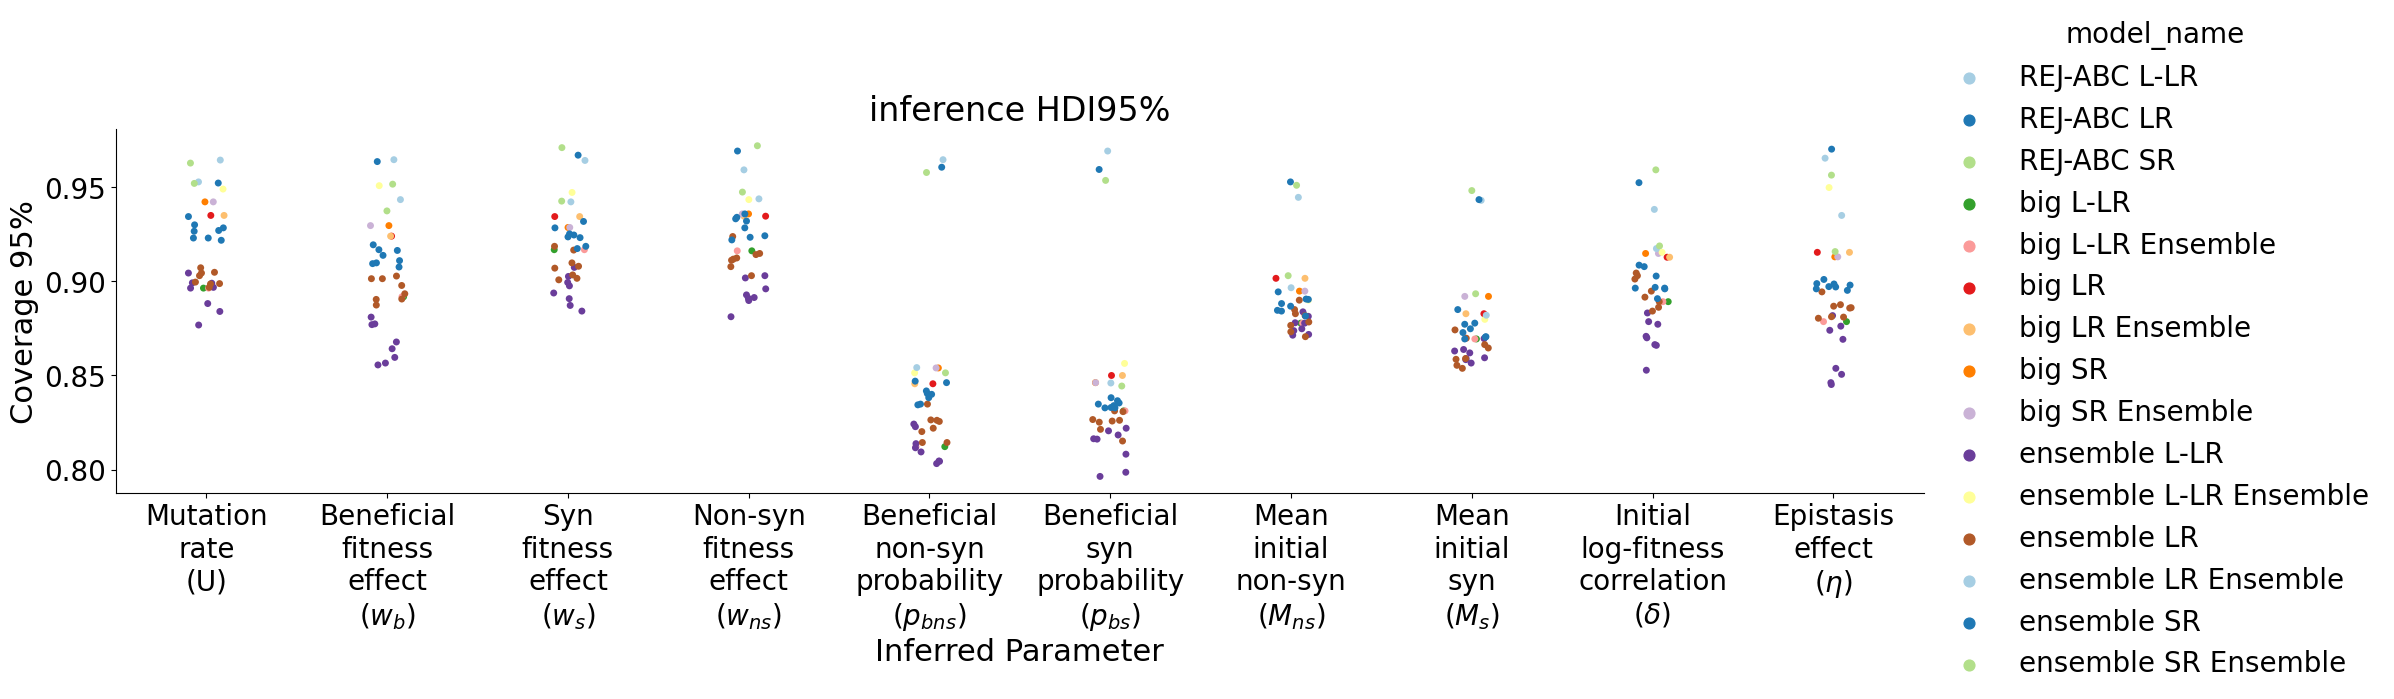

In [7]:
def fix_x_ticks():
    x_names = ['\n'.join(v.split(' ')) for v in rename_dict.values()]
    plt.xticks(range(10), x_names)

def compare_grids_coverage(grids, palette='Paired'):
    data = []
    for grid_name, grid in grids.items():
        if 'rej' in grid_name:
            continue
        datum = grid.groupby(['Inferred Parameter','model']).in_range.mean().reset_index()
        datum['model_name'] = grid_name
        datum.loc[datum.model=='ensemble','model_name'] = grid_name + ' Ensemble'
        data.append(datum)
    data = pd.concat(data)
    sns.catplot(data=data.sort_values('model_name'), x='Inferred Parameter', y='in_range',  height=5, aspect=4, 
                hue='model_name', order=rename_dict.values(), palette=palette)
    plt.ylabel('Coverage 95%')
    plt.title('inference HDI95%')
    fix_x_ticks()

compare_grids_coverage(grids_low_errs)


## Fig S2

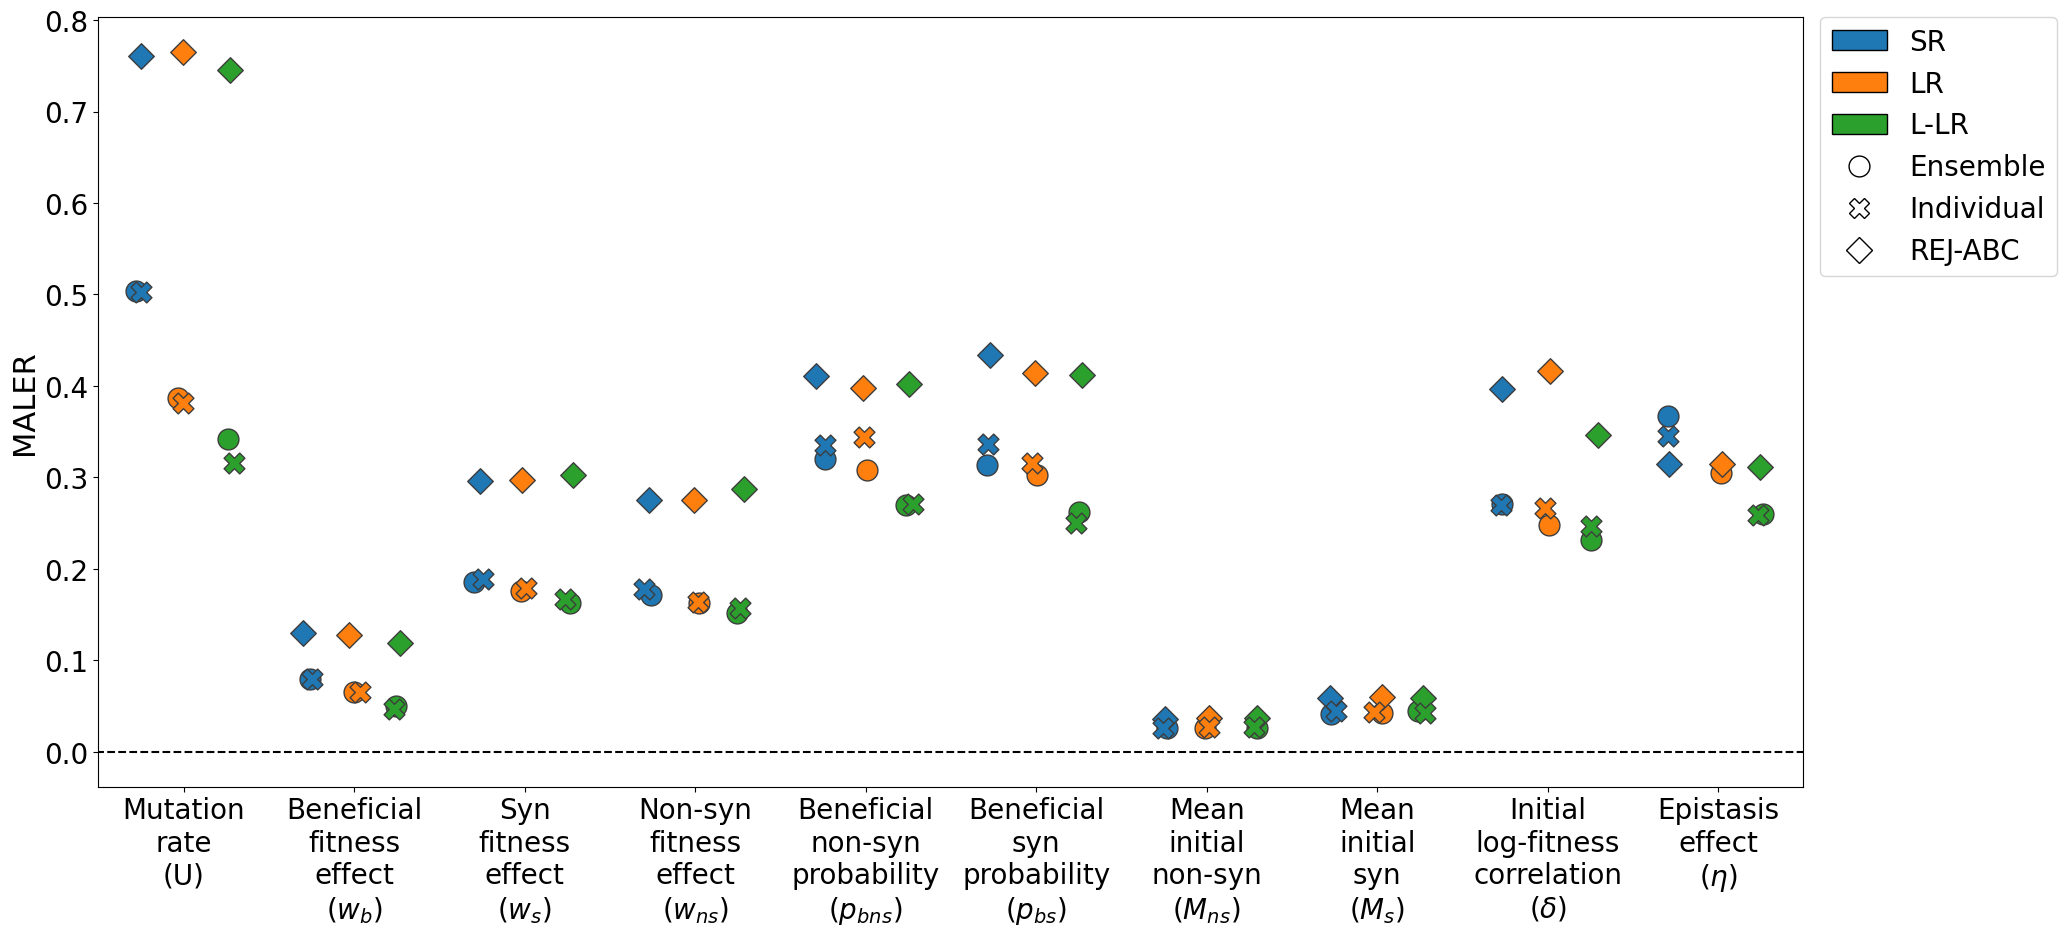

In [17]:
def mabs(col):
    return np.mean(abs(col))

def S1_S2_legend(marker_size):
    handles = []
    handles.append(mpatches.Patch(facecolor='C0', label='SR', edgecolor='k'))
    handles.append(mpatches.Patch(facecolor='C1', label='LR', edgecolor='k'))
    handles.append(mpatches.Patch(facecolor='C2', label='L-LR', edgecolor='k'))
    # handles.append(mpatches.Patch(facecolor='C3', label='Revision L-LR', edgecolor='k'))
    handles.append(plt.Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='white',
                              label='Ensemble', linestyle='None', markersize=marker_size))
    handles.append(plt.Line2D([0], [0], marker='X', markeredgecolor='k', markerfacecolor='white', 
                              label='Individual', linestyle='None', markersize=marker_size))
    handles.append(plt.Line2D([0], [0], marker='D', markeredgecolor='k', markerfacecolor='white',
                              label='REJ-ABC', linestyle='None', markersize=marker_size-2))    
    plt.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

def plot_RMSEs(grids, palette=None):
    plt.figure(figsize=(22,10))
    col = 'err_ratio'
    data = []
    marker_size = 15
    for grid_name, grid in grids.items():
        datum = grid.groupby(['Inferred Parameter','model'])[col].apply(mabs).reset_index()
        if 'big' in grid_name:
            datum = datum[datum.model!='ensemble']
        datum['model_name'] = grid_name
        datum.loc[datum.model=='ensemble','model_name'] = grid_name + ' Ensemble'
        data.append(datum)
    data = pd.concat(data)
    plt.plot([-0.9,10], [0,0], '--k')
    ens = data[(data.model=='ensemble')]
    g = sns.stripplot(data=ens, x='Inferred Parameter', y=col, label='_nolegend', order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size, linewidth=1, palette=palette)
    rej = data[(data.model=='rej')]
    g = sns.stripplot(data=rej, x='Inferred Parameter', y=col, label='_nolegend', order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size-2, linewidth=1, palette=palette, marker='D')
    big = data[(data.model=='big_model.dill')]
    sns.stripplot(data=big, x='Inferred Parameter', y=col, marker='X', label='_nolegend',order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size, linewidth=1, palette=palette)
    plt.ylabel('MALER')
    plt.xlabel('')
    S1_S2_legend(marker_size)
    fix_x_ticks()
    # plt.savefig('figs2_rev.pdf', bbox_inches='tight')
    
plot_RMSEs(grids_low_errs)

In [9]:
grids_low_errs

{'ensemble SR':         Unnamed: 0            param      mode  hdi95_low       DKL  \
 0                0               mu -3.057000  -3.922266  4.915344   
 1                1            w_syn  0.298000   0.102649  1.041673   
 2                2        w_non_syn  0.138000   0.011043  1.098810   
 3                3            w_ada  1.275500   1.001676  1.045471   
 4                4        p_ada_syn  0.005930   0.001258  0.629472   
 ...            ...              ...       ...        ...       ...   
 134995      134995    p_ada_non_syn  0.003140   0.000242  0.742925   
 134996      134996           p0_syn  0.491000   0.400307  0.619399   
 134997      134997       p0_non_syn  0.803000   0.713670  0.619905   
 134998      134998        w_penalty  1.407500   0.506125  0.700669   
 134999      134999  epistasis_boost -0.019902  -0.999784  0.785267   
 
         hdi95_high  hdi50_low  hdi50_high  value       err  in_range  \
 0        -1.483378  -3.235156   -2.282894 -3.971  0.91400

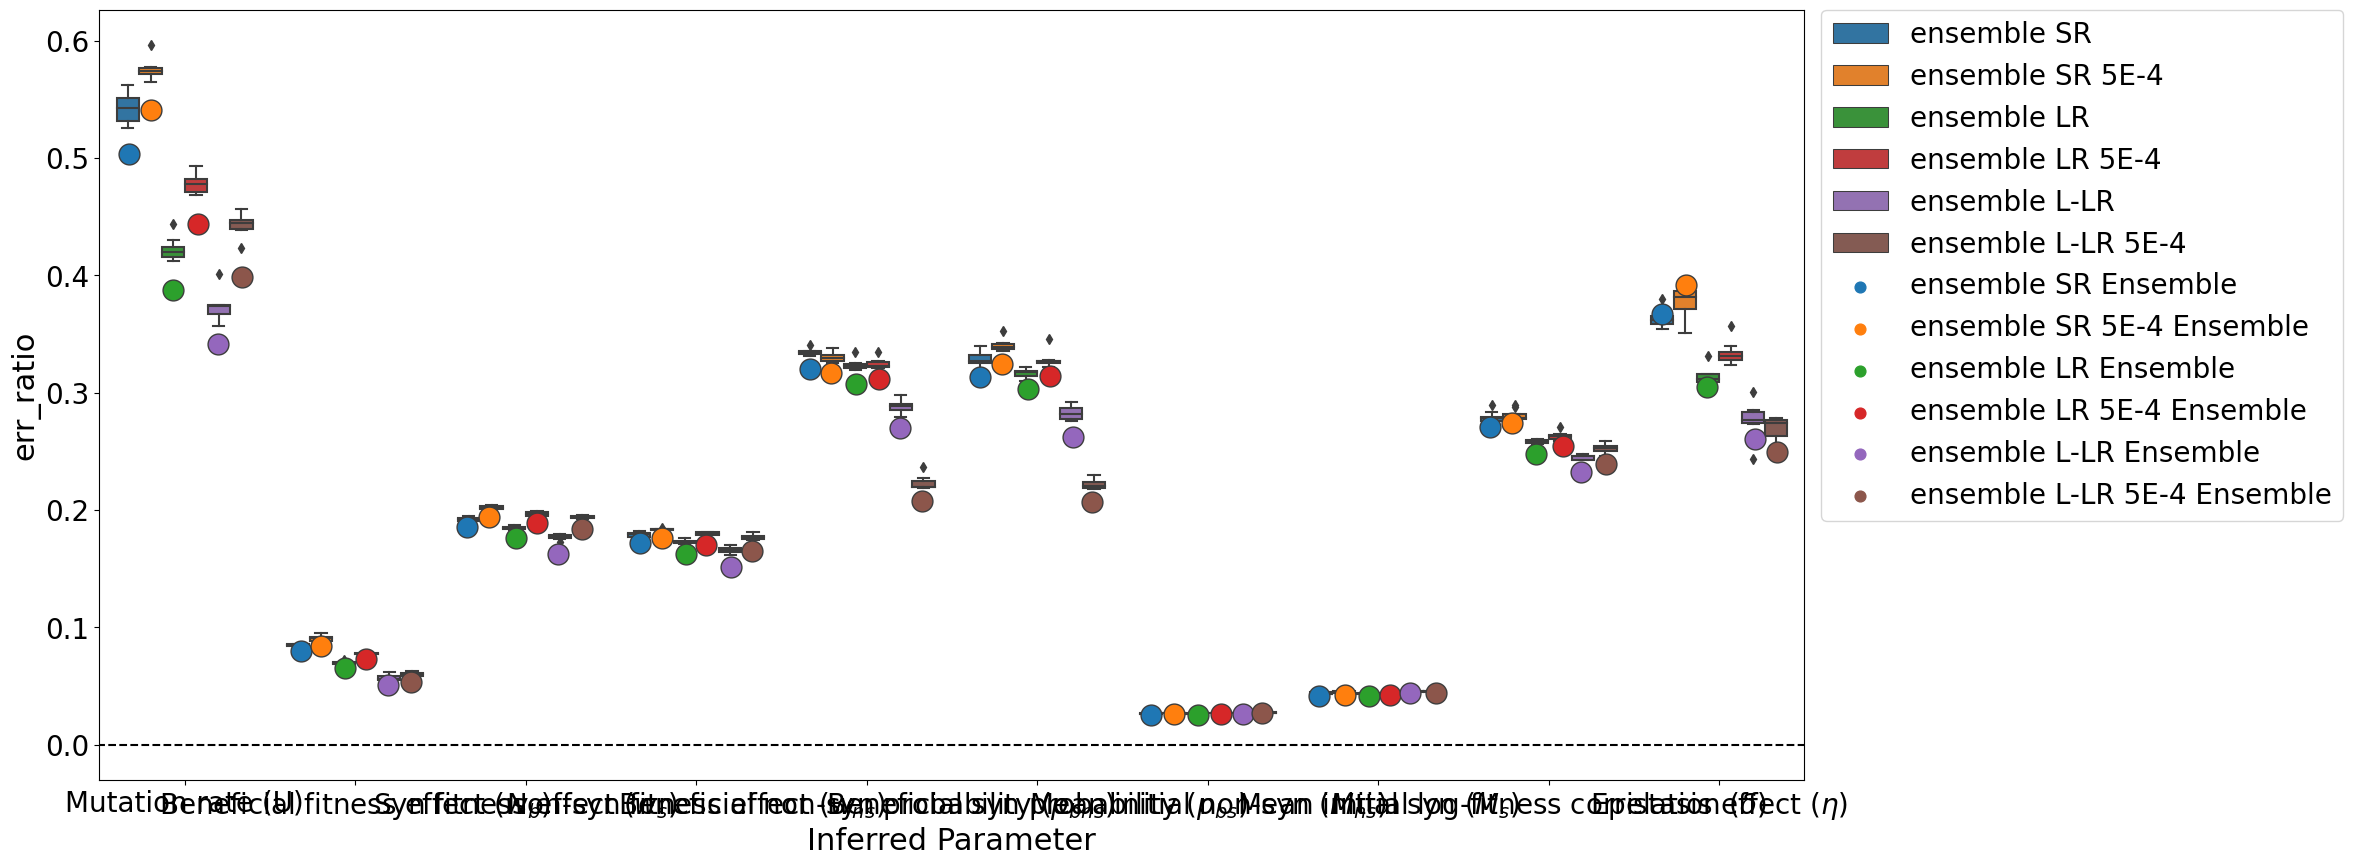

In [18]:
plt.figure(figsize=(22,10))
col = 'err_ratio'
palette = None
data = []
marker_size = 15
for grid_name, grid in grids.items():
    datum = grid.groupby(['Inferred Parameter','model'])[col].apply(mabs).reset_index()
    if 'big' in grid_name:
        datum = datum[datum.model!='ensemble']
    datum['model_name'] = grid_name
    datum.loc[datum.model=='ensemble','model_name'] = grid_name + ' Ensemble'
    data.append(datum)
data = pd.concat(data)
ens = data[(data.model=='ensemble')]
smalls = data[(data.model!='ensemble') & (data.model!='big_model.dill')  & (data.model!='rej')]
sns.boxplot(data=smalls, x='Inferred Parameter', y=col,
            hue='model_name', order=rename_dict.values(), palette=palette)
plt.plot([-0.9,10], [0,0], '--k')
g = sns.stripplot(data=ens, x='Inferred Parameter', y=col, label='_nolegend', order=rename_dict.values(),
          hue="model_name", dodge=True, size=marker_size, linewidth=1, palette=palette)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

# Fig S1

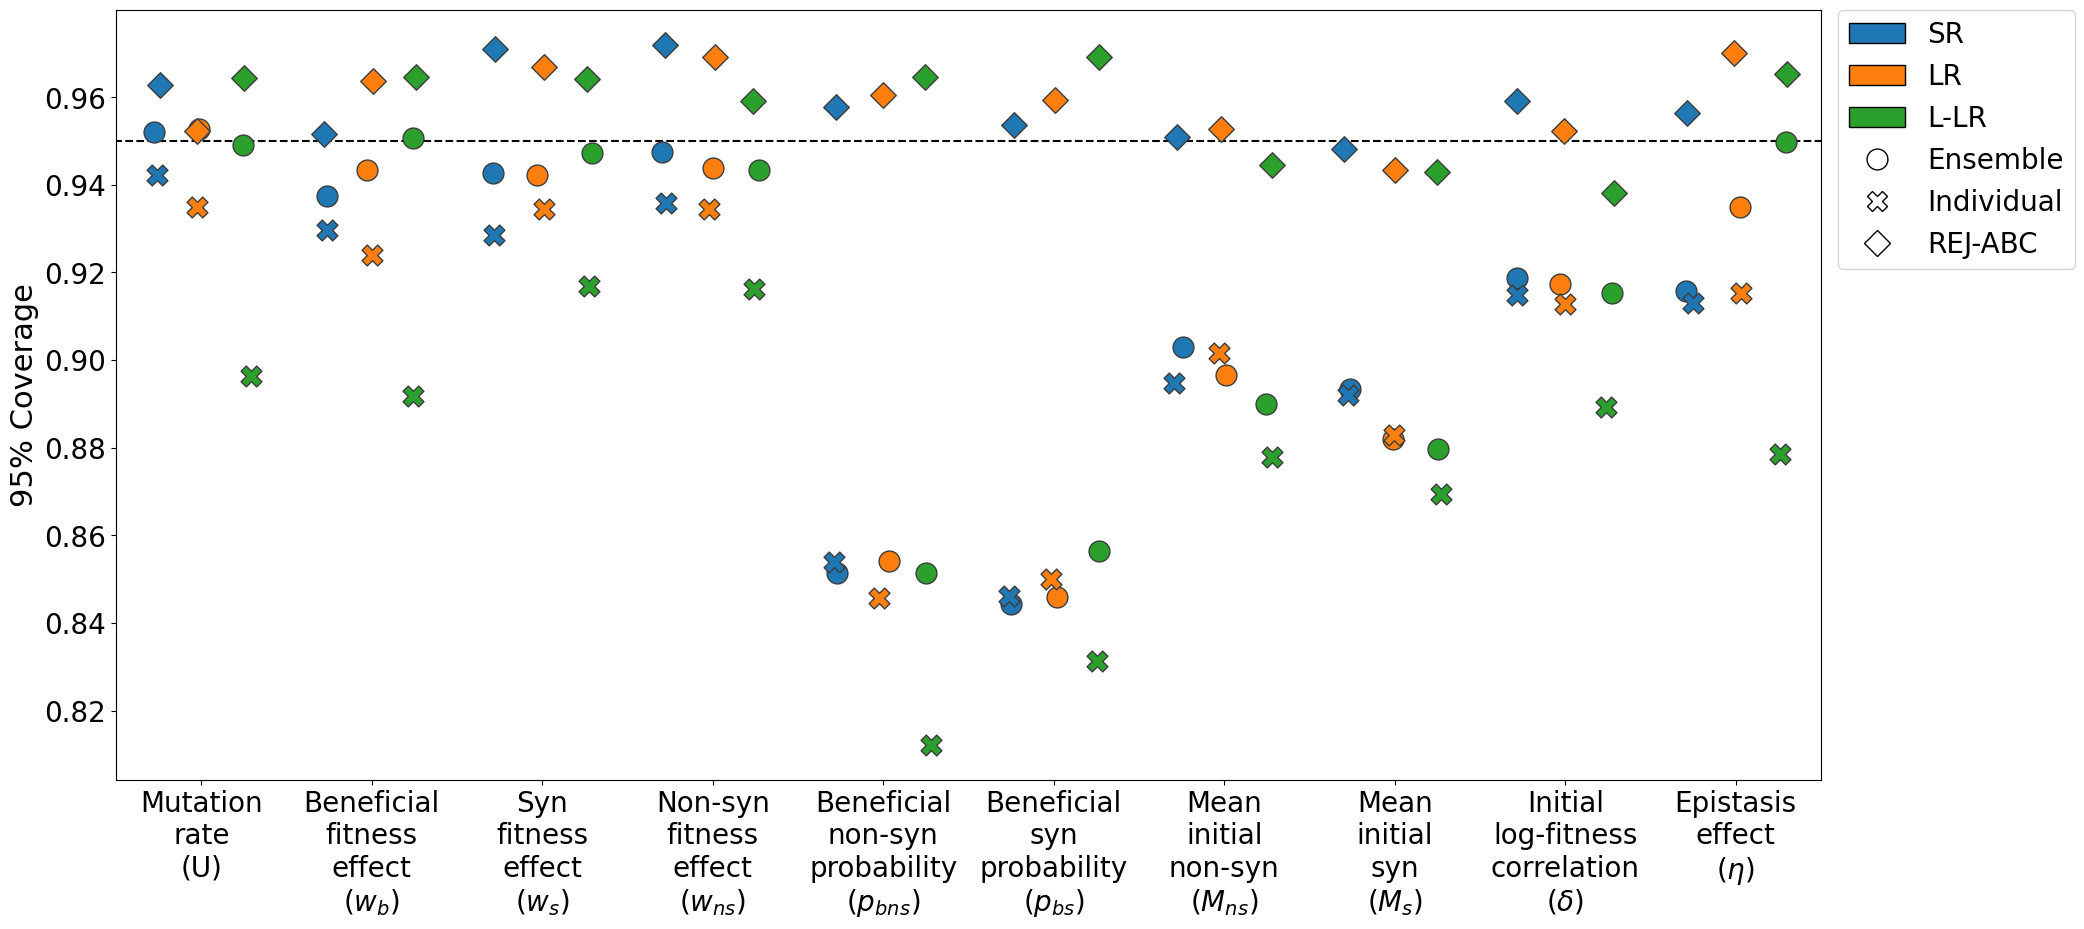

In [19]:
def plot_coverage(grids, palette=None):
    plt.figure(figsize=(22,10))
    data = []
    marker_size = 15
    for grid_name, grid in grids.items():
        datum = grid.groupby(['Inferred Parameter','model']).in_range.mean().reset_index()
        if 'big' in grid_name:
            datum = datum[datum.model!='ensemble']
        datum['model_name'] = grid_name
        datum.loc[datum.model=='ensemble','model_name'] = grid_name + ' Ensemble'
        data.append(datum)
    data = pd.concat(data)
    plt.plot([-0.9,10], [0.95,0.95], '--k')
    ens = data[(data.model=='ensemble')]
    g= sns.stripplot(data=ens, x='Inferred Parameter', y='in_range', label='_nolegend',order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size, linewidth=1, palette=palette)
    rej = data[(data.model=='rej')]
    g = sns.stripplot(data=rej, x='Inferred Parameter', y='in_range', label='_nolegend', order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size-2, linewidth=1, palette=palette, marker='D')
    big = data[(data.model=='big_model.dill')]
    g = sns.stripplot(data=big, x='Inferred Parameter', y='in_range', marker='X', label='_nolegend',order=rename_dict.values(),
              hue="model_name", dodge=True, size=marker_size, linewidth=1, palette=palette)

    plt.ylabel('95% Coverage')
    plt.xlabel('')
    S1_S2_legend(marker_size)
    fix_x_ticks()
    # plt.savefig('figs1_rev.pdf', bbox_inches='tight')
plot_coverage(grids_low_errs, None)


In [8]:
shorts = {k: v for k,v in grids.items() if 'short' in k}
longs = {k: v for k,v in grids.items() if 'long' in k}
mans = {k: v for k,v in grids.items() if 'man' in k}
not_big = {k: v for k,v in grids.items() if 'big' not in k}

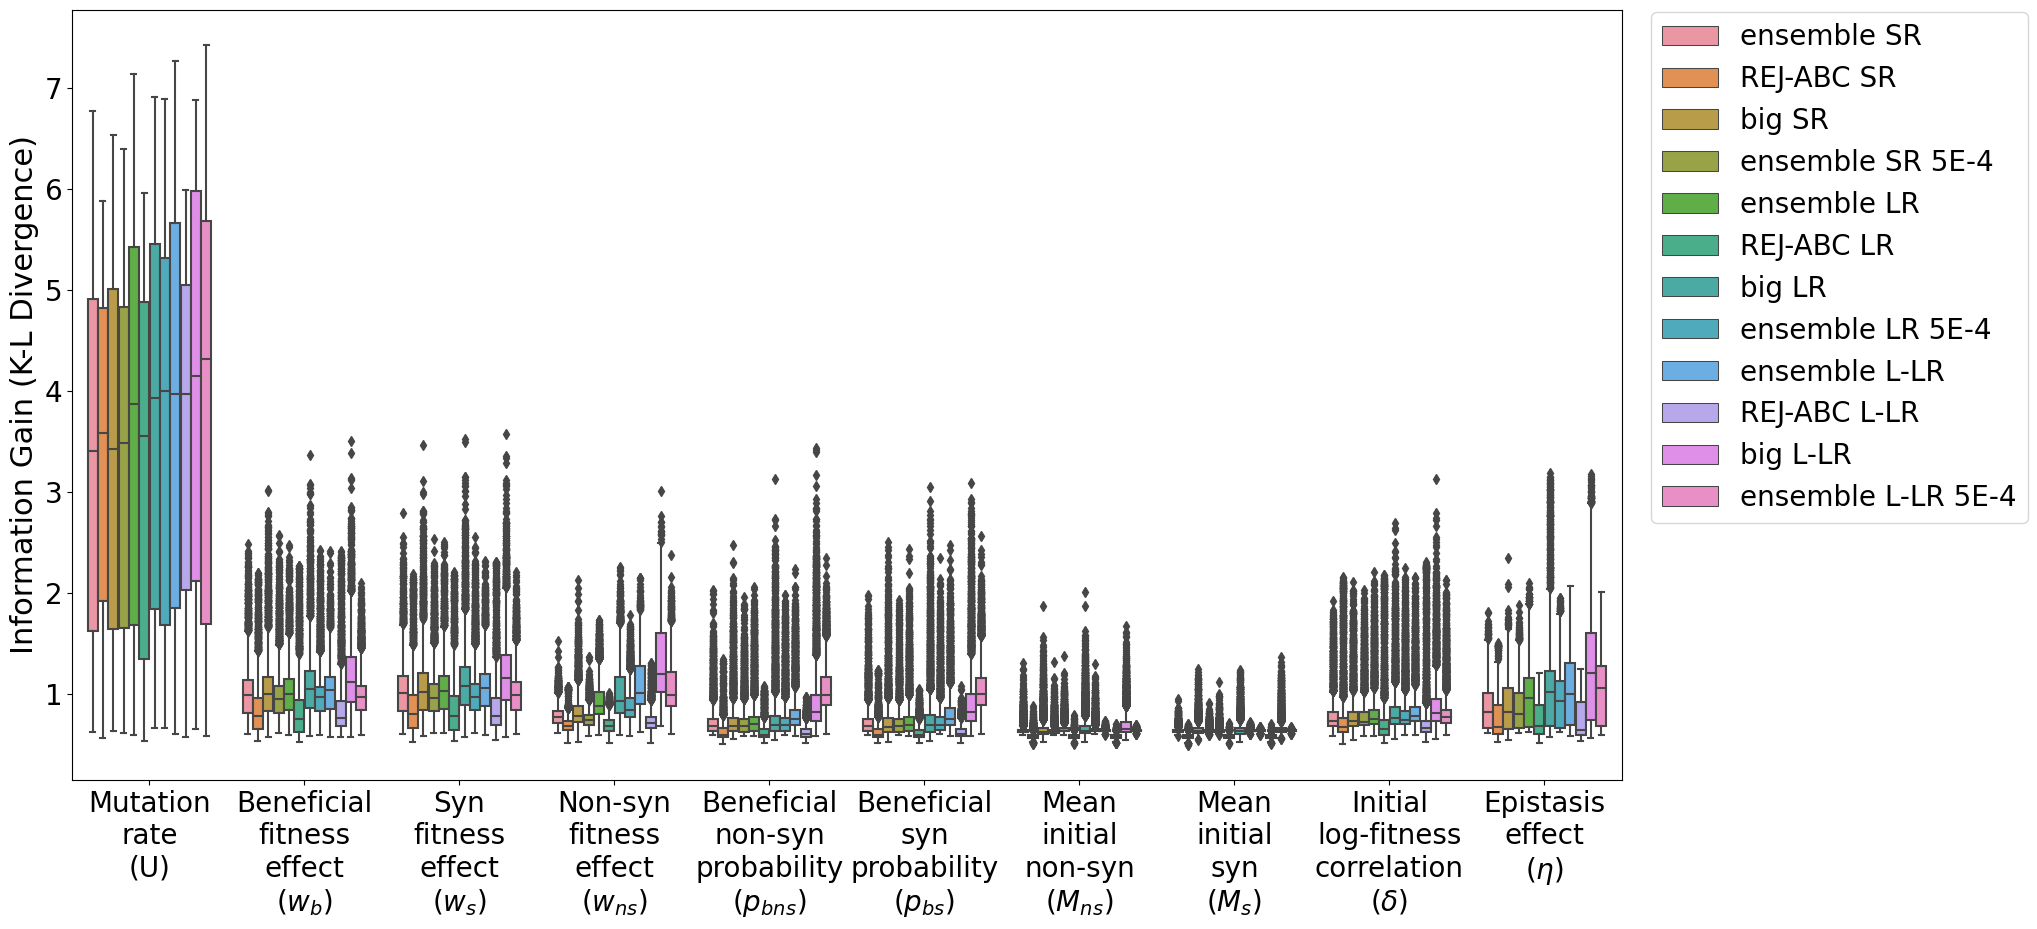

In [22]:
def compare_grids_DKL(grids):
    data = []
    for grid_name, grid in grids.items():
        datum = grid.copy()
        if 'REJ' not in grid_name:
            datum = datum[datum.model=='ensemble']
        datum['model_name'] = grid_name
        data.append(datum)
    data = pd.concat(data)
    data.param = data.param.map(lambda p: rename_dict[p])
    plt.figure(figsize=(20,10))
    sns.boxplot(data=data, x='param', y='DKL', hue='model_name')
    plt.ylabel('Information Gain (K-L Divergence)')
    plt.legend(bbox_to_anchor=(1.01,1.015))
    plt.xlabel('')
    fix_x_ticks()
    # plt.savefig('figs3_rev.pdf', bbox_inches='tight')
compare_grids_DKL(grids)

# Fig S3

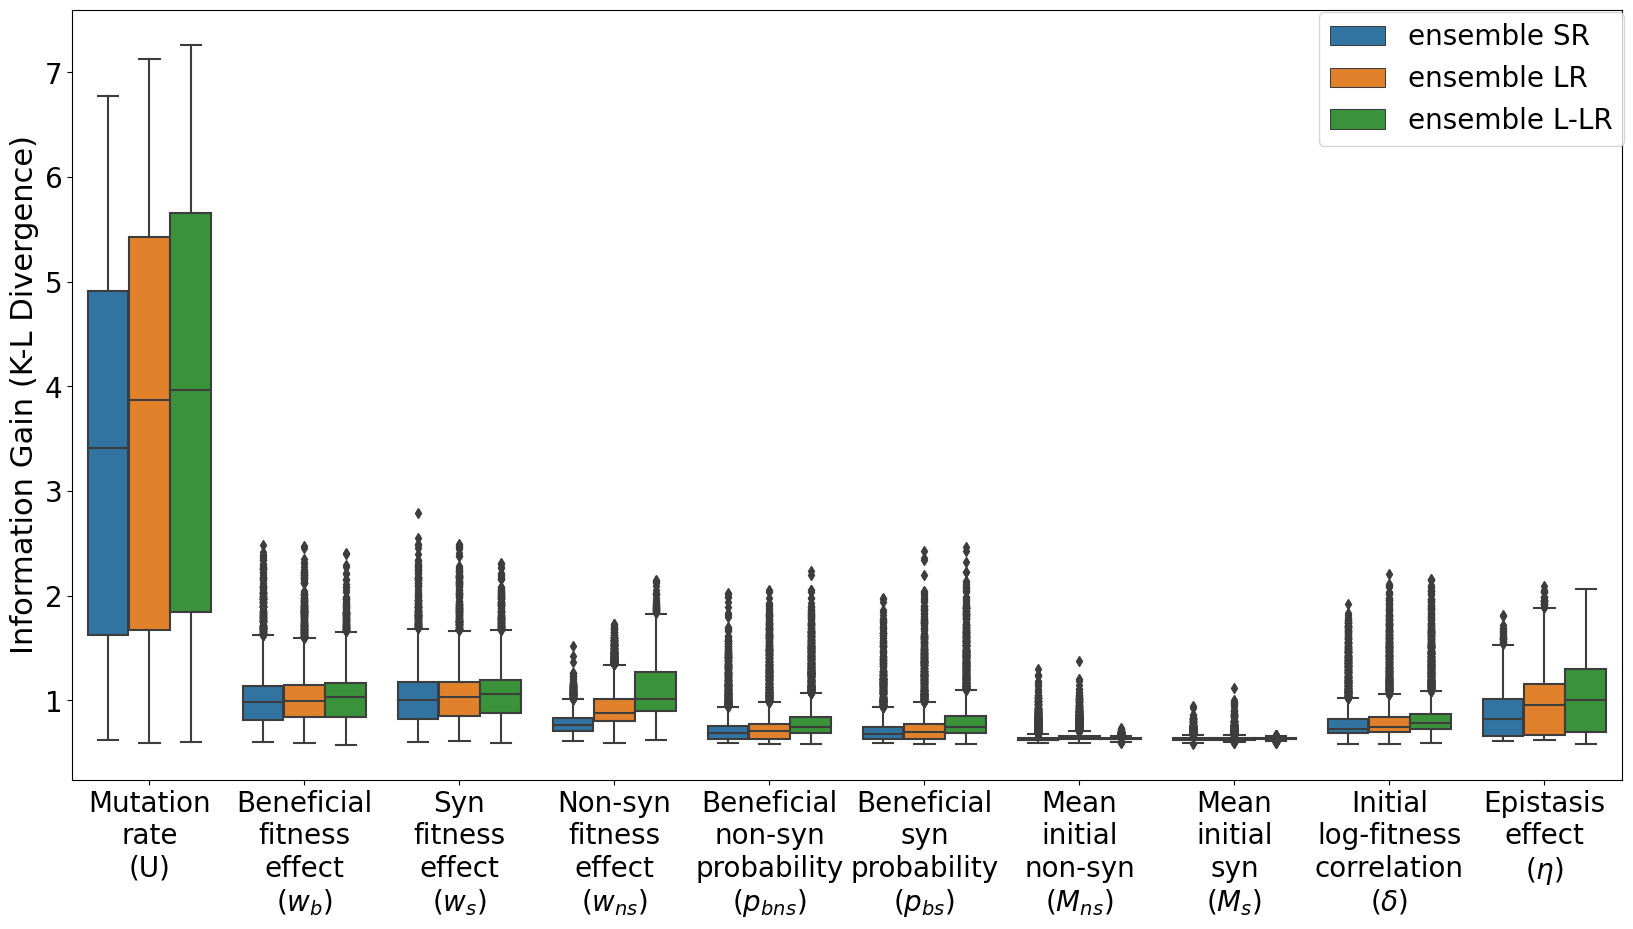

In [23]:
compare_grids_DKL({k: grids[k] for k in ['ensemble SR', 'ensemble LR', 'ensemble L-LR', 'revision - double passage']})

In [9]:
import matplotlib as mpl

def error_hists(data_dict, colors=None, bins=20):
    mosaic = """
        AAA
        AAA
        BCD
        EFG
        """
    fig = plt.figure(constrained_layout=True, figsize=(16,12))
    fig.supxlabel('\nMAP Error Ratio')
    mpl.rcParams["image.aspect"] = 'auto'
    ax_dict = fig.subplot_mosaic(mosaic)
    param_to_plot_dict = {'Mutation rate (U)': 'A', r'Syn fitness effect ($w_{s}$)': 'B',
                          r'Non-syn fitness effect ($w_{ns}$)': 'C', 
                          r'Beneficial syn probability ($p_{bs}$)': 'D', 
                          r'Beneficial fitness effect ($w_{b}$)': 'E', 
                          r'Epistasis effect ($\eta$)': 'F', 
                          r'Beneficial non-syn probability ($p_{bns}$)': 'G'}
    legend = True
    if not colors:
        colors = sns.color_palette(None)
    for param in list(data_dict.values())[0]['Inferred Parameter'].unique():
        if param not in param_to_plot_dict.keys():
            continue
        for i, (grid_name, grid) in enumerate(data_dict.items()):
            tmp = grid[(grid['Inferred Parameter']==param)]
            if 'REJ' not in grid_name and 'BIG' not in grid_name:
                tmp = tmp[(tmp['model']=='ensemble')]
            ax = ax_dict[param_to_plot_dict[param]]
            col = 'err' if 'Mutation' in param else 'rel_err'
            histtype = 'bar'
            
            if 'REJ' in grid_name:
                histtype = 'step'
            h=tmp[col].sample(1000, replace=True).hist(bins=bins, alpha=0.5, label=grid_name if legend else '_nolegend', ax=ax,
                                       color=colors[i], histtype=histtype, density=True)
            f = lambda x: str(round(10**x)) if (x==0 or x>=1) else str(round(10**x,3))
            new_xticks = np.array(list(map(f, h.get_xticks())))
            ax.set_xticklabels(new_xticks)
            
            if 'big' in grid_name:
                rmse_big = np.mean(tmp[col]**2)
            else:
                rmse = np.mean(tmp[col]**2)
        xlabel = param.replace('\n', ' ')
        ax.set_xlabel('')#log10(MAP Error Ratio)')
        if param_to_plot_dict[param] in ['A','B','E']:
            ax.set_ylabel('Density')
        ax.set_title(xlabel)
        legend = False
    fig.legend(loc=(0.65,0.75))
    fig.savefig('fig3.tif', bbox_inches='tight', dpi=500)


# Fig 3

/tmp/ipykernel_3555667/3463095188.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_xticks)


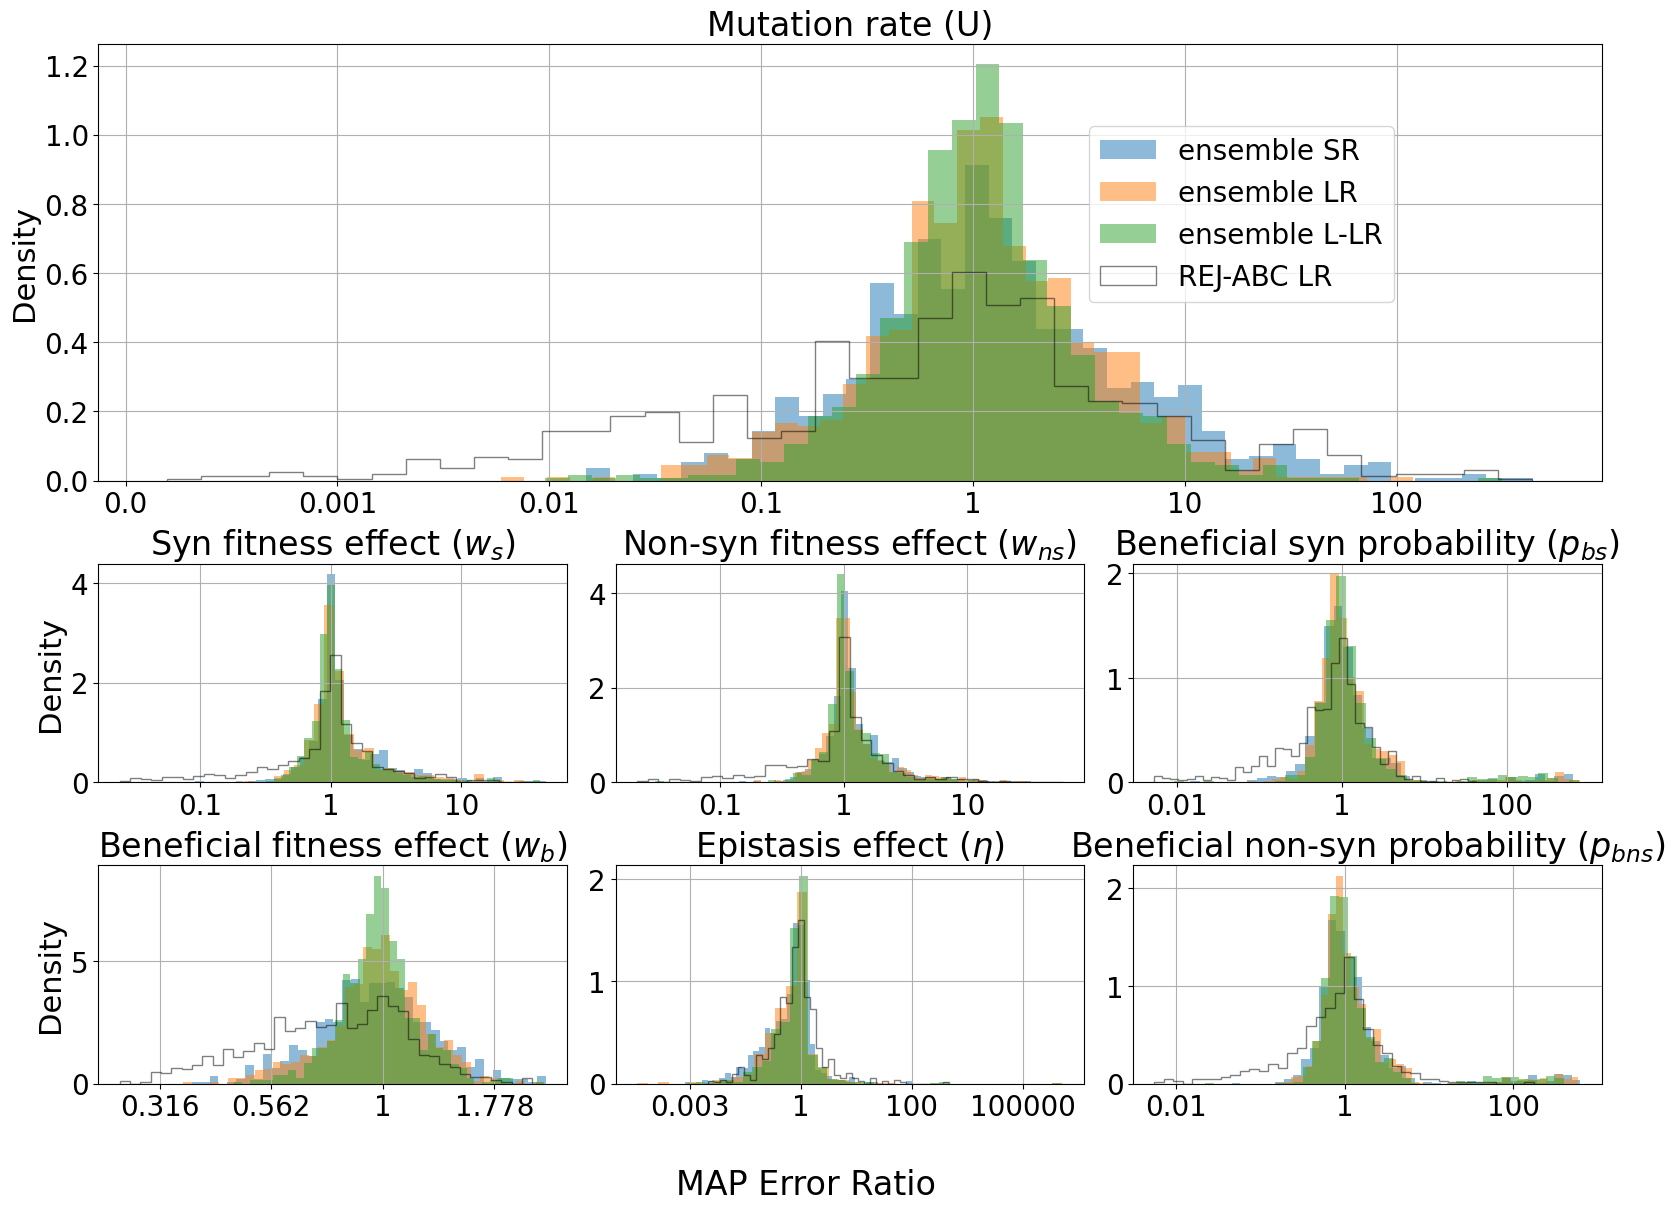

In [10]:
error_hists({k: grids[k] for k in ['ensemble SR', 'ensemble LR', 'ensemble L-LR', 'REJ-ABC LR']}, colors=sns.color_palette(None)[:3]+['k','red'], bins=40)

In [9]:
def difficult_regions_global(err_above=0.5, model = 'ensemble'):
    df = grids['ensemble L-LR']
    columns = list(df['param'].unique())+['error in', 'error pct']
    print(columns)
    df.loc[:,'err'] = np.abs(df.loc[:,'err']) / np.abs(df.loc[:,'value'])
    df = df[df['model'] == model]
    df = df.sort_values(by='err', ascending=False)
    df = df[df['err'] >= err_above]
    df = df.iloc[:,1:]
    df = df.loc[:, ['param', 'mode', 'value','theta']]
    
    n = len(df)
    real_params = pd.DataFrame(index = [i for i in range(n)], columns=columns)
    for i in range(len(df)):
        real_params.iloc[i,:-2] = df.iloc[i,:]['theta'].split('_')
        real_params.iloc[i,-2:] = df.loc[i,['param','err']]
    for j in range(len(real_params.columns)):
        real_params.iloc[:,j] = round(real_params.iloc[:,j].astype('float'),7)
        

# New Fig (Reviewer 1)

In [25]:
import matplotlib as mpl
from scipy.stats import pearsonr as corr, kde
import re
label_size = 10
font_size = 14
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['font.size'] = label_size



readable_prior = {'mu' : (-4,0.3),
                  'w_syn': (0.01,1),
                  'w_non_syn': (0.01,1),
                  'w_ada': (1,3),
                  'p_ada_syn': (0, 0.01),
                  'p_ada_non_syn': (0, 0.01),
                  'p0_syn': (0.4,0.6),
                  'p0_non_syn': (0.7,0.9),
                  'w_penalty': (0,2),
                  'epistasis_boost': (-1,3)}


fig4_data = grids['revision - double passage']

def fig4(ax, df, param, legend=False):
    p_df = df[df['param'] == param]
    p_df = p_df[p_df['model'] == 'ensemble']
    
    x,y = p_df['value'], p_df['mode']
    reparam = rename_dict[param]
    m = re.search('\(.*\)',reparam)[0][1:-1]
    
    rho = '$\\rho$'
    ax.set_title(f'{rho} ={round(corr(x,y)[0],2)}', fontsize=font_size)
    ax.set_xlabel(f'True {m}\n', fontsize=font_size)
    ax.set_ylabel(f'Predicted {m}', fontsize=font_size)
    ax.plot(x, x, color = 'white', label = 'y=x', linewidth=2) # y=x
    
    nbins=200
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    cax = ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
    if param=='mu':
        #cbar = plt.colorbar(cax, ax=ax)
        #cbar.ax.set_yticklabels(['low density'] + ['' for i in range(len(cbar.ax.get_yticklabels())-3)] + ['high density'])
        ax.set_xticklabels([round(10**float(x),3) for x in ax.get_xticks()])
        ax.set_yticklabels([round(10**float(x),3) for x in ax.get_xticks()])
    #ax.scatter(x, y, color = 'teal', label = 'MAP')
    if legend:
        ax.legend(fontsize=font_size, loc='upper left')
    #limits = readable_prior[param]
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(),y.max())
    return cax


/tmp/ipykernel_2798096/2399582885.py:41: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x,y])
/tmp/ipykernel_2798096/2399582885.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([round(10**float(x),3) for x in ax.get_xticks()])
/tmp/ipykernel_2798096/2399582885.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(10**float(x),3) for x in ax.get_xticks()])
/tmp/ipykernel_2798096/3698892763.py:26: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(right=0.8,wspace=0.35, hspace=0.65)
/tmp/ipykernel_2798096/3698892763.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['low density'] + ['' for i in rang

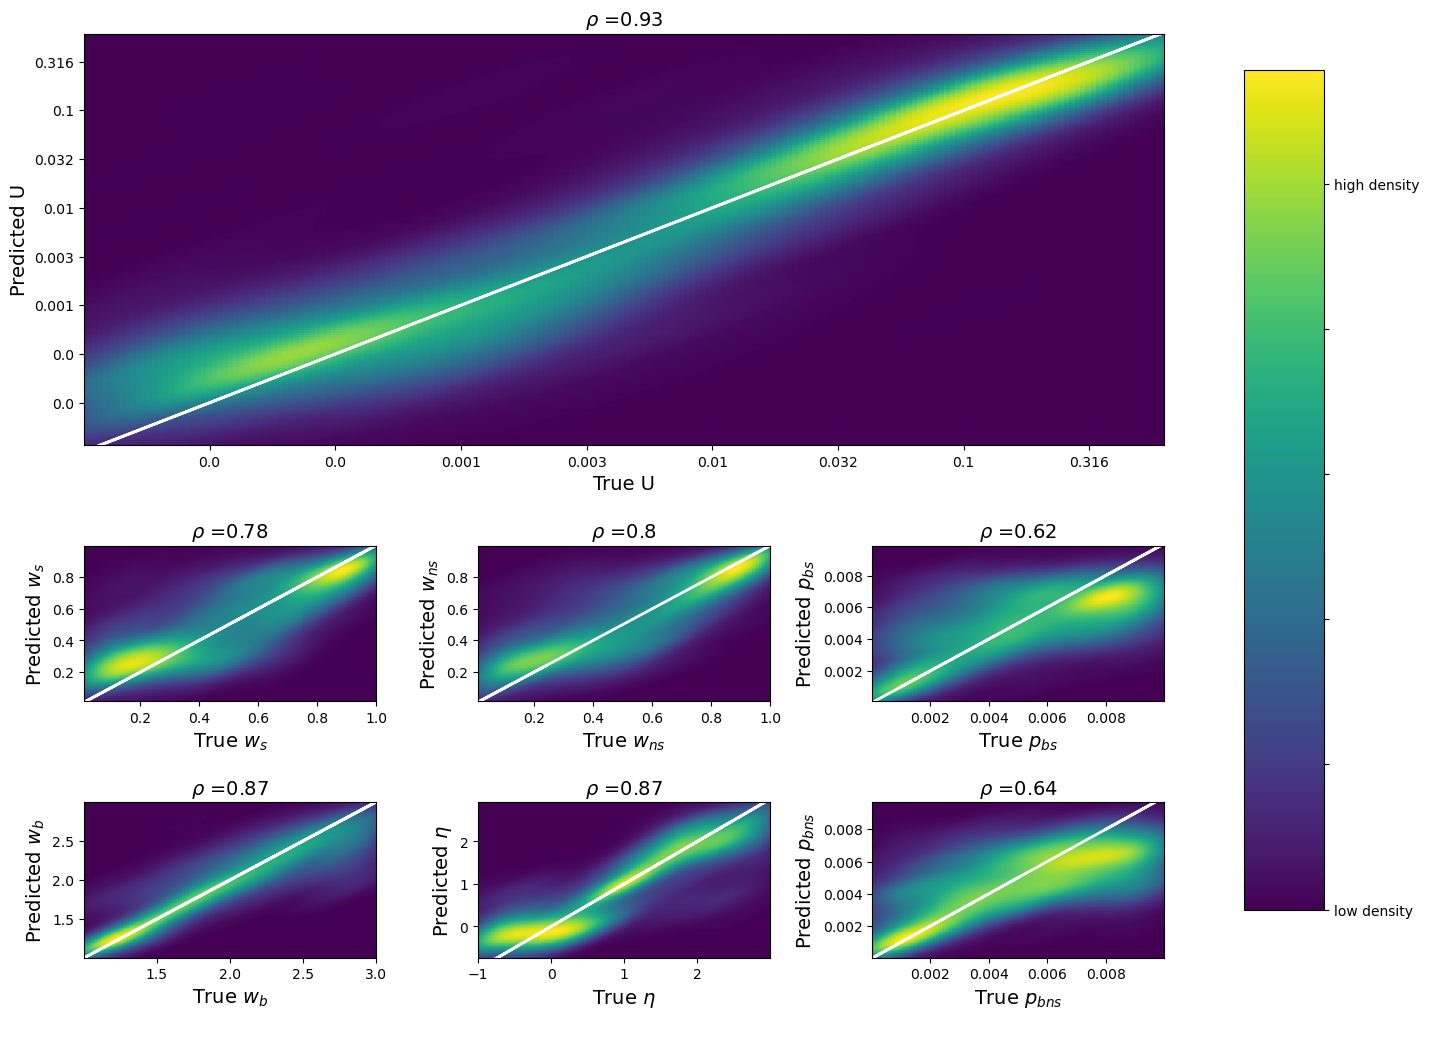

In [27]:
def new_fig4_mosaic(df):
    mosaic = """
            AAA
            AAA
            BCD
            EFG
            """
    fig = plt.figure(constrained_layout=True, figsize=(16,12))
    #fig.tight_layout(h_pad=10, w_pad=10)
    mpl.rcParams["image.aspect"] = 'auto'
    ax_dict = fig.subplot_mosaic(mosaic)
    param_to_plot_dict = {'Mutation rate (U)': 'A', r'Syn fitness effect ($w_{s}$)': 'B',
                          r'Non-syn fitness effect ($w_{ns}$)': 'C', 
                          r'Beneficial syn probability ($p_{bs}$)': 'D', 
                          r'Beneficial fitness effect ($w_{b}$)': 'E', 
                          r'Epistasis effect ($\eta$)': 'F', 
                          r'Beneficial non-syn probability ($p_{bns}$)': 'G'}
    legend = True
    
    params = list(df['param'].unique())
    for param in params:
        reparam = rename_dict[param]
        if 'Mean' not in reparam and 'Initial' not in reparam:
            rel_ax = ax_dict[param_to_plot_dict[reparam]]
            cax=fig4(rel_ax, fig4_data, param) 
    fig.subplots_adjust(right=0.8,wspace=0.35, hspace=0.65)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(cax, cax=cbar_ax)
    cbar.ax.set_yticklabels(['low density'] + ['' for i in range(len(cbar.ax.get_yticklabels())-3)] +['high density'])  
    fig.savefig('fig4_reviewer - 2 passages.pdf')

new_fig4_mosaic(grids['revision - double passage'])

# Study Difficult Regions in Parameter Estimation

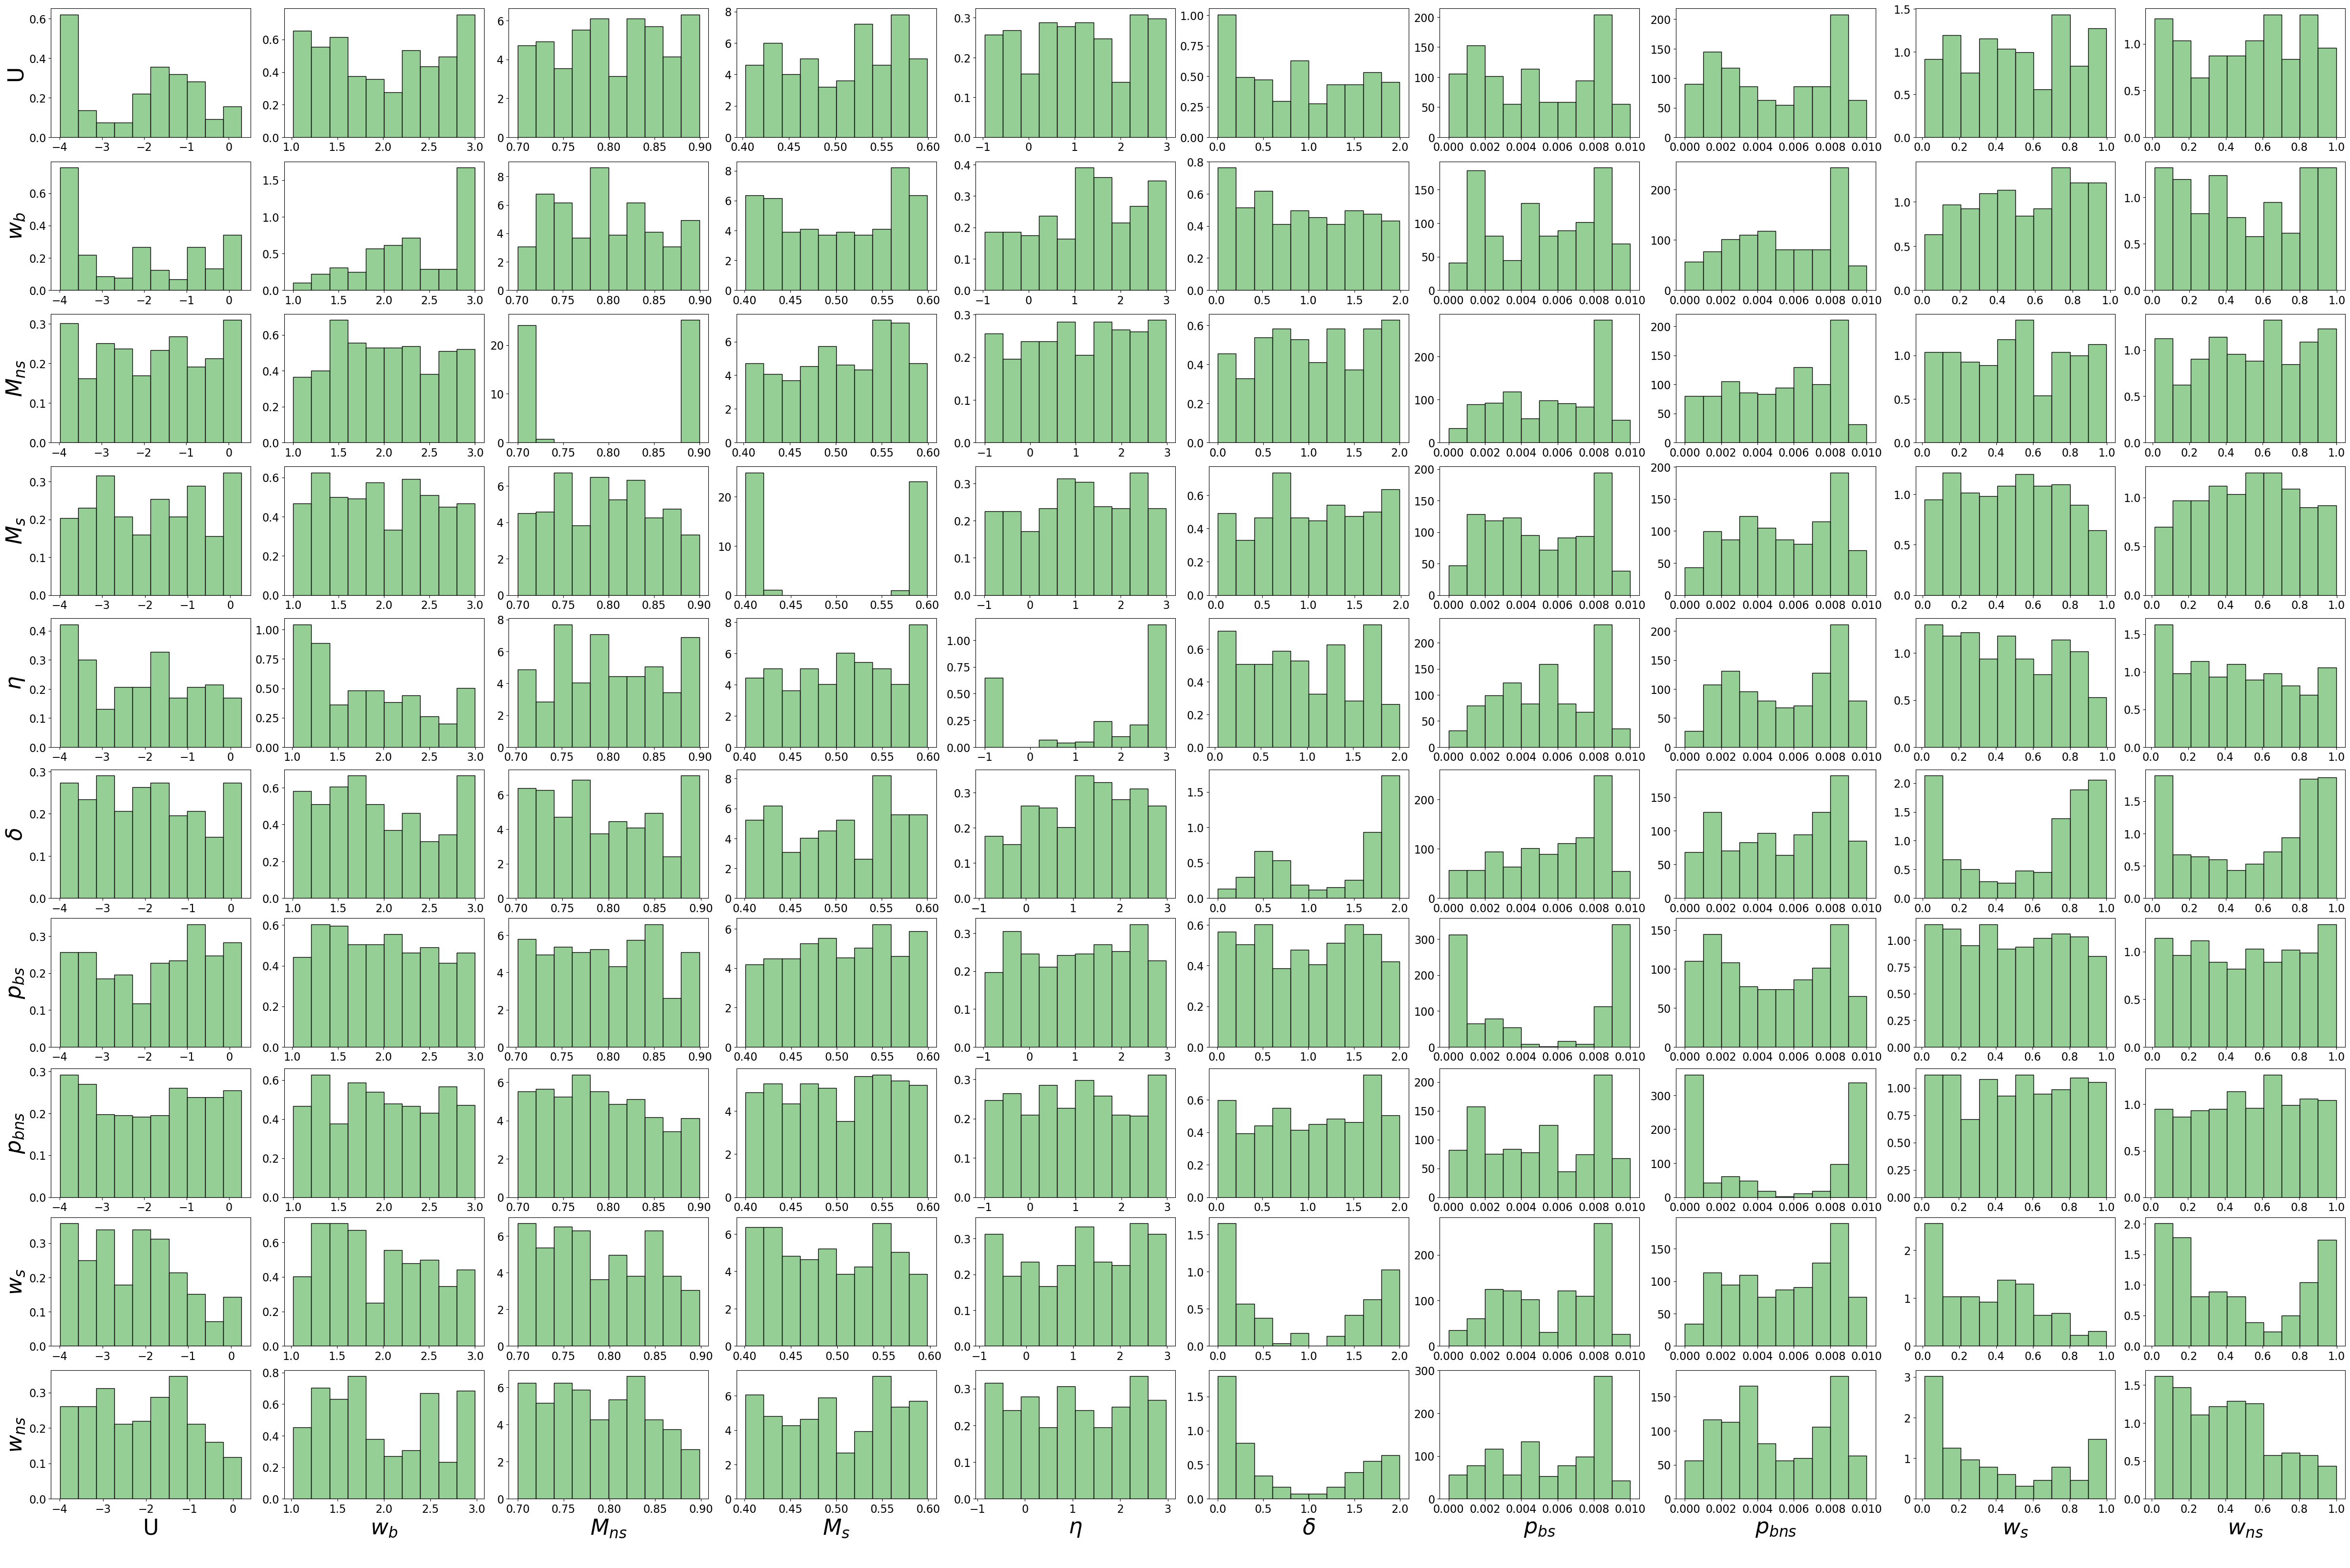

In [208]:
from seaborn import histplot as hst

label_size = 32
mpl.rcParams['xtick.labelsize'] = label_size-16
mpl.rcParams['ytick.labelsize'] = label_size-16 
mpl.rcParams['font.size'] = label_size

readable_prior = {'mu' : (-4,0.3),
                  'w_syn': (0.01,1),
                  'w_non_syn': (0.01,1),
                  'w_ada': (1,3),
                  'p_ada_syn': (0, 0.01),
                  'p_ada_non_syn': (0, 0.01),
                  'p0_syn': (0.4,0.6),
                  'p0_non_syn': (0.7,0.9),
                  'w_penalty': (0,2),
                  'epistasis_boost': (-1,3)}


fig, ax = plt.subplots(10,10,constrained_layout=True, figsize=(48,32))
#fig.tight_layout(pad=6)
x = fig4_data[fig4_data['in_range']==False]

x = x[x['model']=='ensemble']
diff_df = pd.DataFrame(index = [i for i in range(len(x))], columns =['param']+list(fig4_data['param'].unique()))
for i in range(len(x)):
    param = x.iloc[i,:]['param']
    theta = x.iloc[i,:]['theta'].split('_')
    diff_df.iloc[i,:] = [param]+theta

for i in range(10):
    param_x = diff_df['param'].unique()[i]
    p_x = diff_df[diff_df['param']==param_x]
    y=fig4_data[fig4_data['param']==param_x]
    
    for j in range(10):
        param_y = diff_df['param'].unique()[j]
        plt_x = p_x[param_y].astype('float')
        hst(data = plt_x, ax = ax[i,j], bins = 10, stat='density', color = sns.color_palette(None)[2], alpha=0.5)
        if j==0:
            ax[i,j].set_ylabel(re.search('\(.*\)',rename_dict[param_x])[0][1:-1], fontsize=label_size)
        else:
            ax[i,j].set_ylabel('')
        if i==9:
            ax[i,j].set_xlabel(re.search('\(.*\)',rename_dict[param_y])[0][1:-1]+'\n', fontsize=label_size)
        else:
            ax[i,j].set_xlabel('')

# fig.savefig('diff_regions.pdf', bbox_inches='tight')